## Download the model and metadata if necessary

In [4]:
import os

!pip install yacs opencv-python json_tricks pycocotools

if not os.path.isfile('pose_hrnet_w48_384x288.pth'):
    !curl -O https://eurmqg.ch.files.1drv.com/y4mNy2IRQtZ8_2fiDe8-Usmo4MGjRnWRgb2y3jGIx8wq5PQ4ABVUqSZqaumGtuUfhjQpNN8OlpOQZB3Q5gZ11lif97gLj8zaKgPgyYzFdgd8yIiq8rFWsh5oTIxCh9UTyah8gxiqS9ldmIp24C_zKrNOXrMwttYDiMZdA8XaY-g5t3bt2G37fjfWk6qnkyb7lHUFaW-zUhddzpClyRgYCNZYA/pose_hrnet_w48_384x288.pth

if not os.path.isdir('deep-high-resolution-net.pytorch'):
    !git clone https://github.com/leoxiaobin/deep-high-resolution-net.pytorch.git
    !cd deep-high-resolution-net.pytorch/lib/nms/ && python setup_linux.py build && python setup_linux.py install


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


## Load the libraries and the model

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, 'deep-high-resolution-net.pytorch/lib')
sys.path.insert(1, 'deep-high-resolution-net.pytorch/lib/nms/')
sys.path.insert(2, 'deep-high-resolution-net.pytorch/lib/models/')

import cv2
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms

from config import cfg
from config import update_config
#from core.loss import JointsMSELoss
#from core.function import validate
from core.inference import get_max_preds

import pose_hrnet
#import dataset

In [10]:
class ARGS(object):
    pass
args = ARGS()
args.cfg = 'deep-high-resolution-net.pytorch/experiments/coco/hrnet/w48_384x288_adam_lr1e-3.yaml'
args.opts = ''
args.modelDir = '.'
args.logDir = '.'
args.dataDir = '.'
args.TEST = ARGS()
args.TEST.BATCH_SIZE_PER_GPU = 1
args.WORKERS = 1
args.GPUS = (0)
args.TEST.MODEL_FILE = 'pose_hrnet_w48_384x288.pth'
args.TEST.USE_GT_BBOX = True
update_config(cfg, args)

In [12]:
model = pose_hrnet.get_pose_net(cfg, is_train=False)
model.load_state_dict(torch.load('pose_hrnet_w48_384x288.pth', map_location='cpu'))

<All keys matched successfully>

## Prepare a transformer for normalizing the input

In [13]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transformer = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

In [14]:
def predict(img):
    # let's normalize the image and transform it into a pytorch tensor
    batch = transformer(cv2.resize(img, (384, 288)))
    out = model(batch.unsqueeze(0))
    
    # Ok. Now we need to extract the keypoints from each heatmap¶
    coords, maxvals = get_max_preds(out.clone().cpu().detach().numpy())
    img_h, img_w, _ = img.shape
    mask_h, mask_w = out.shape[2:4]
    return np.append((coords[0] / (mask_w, mask_h) * (img_w, img_h)), maxvals[0], axis=1)

## Let's do a basic test
### First, let's load an image

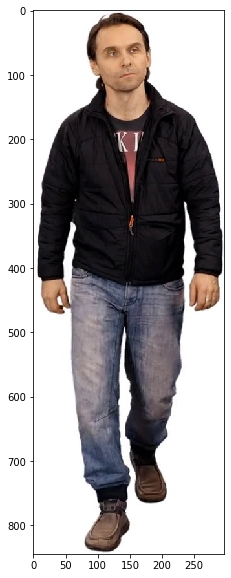

In [62]:
img = cv2.imread('man_walking.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img)

### Now, let's do the prediction
The output in this case is a matrix with the heatmaps for all the 17 keypoints. Each heatmap is a mask with the resolution of W=96 and H=72

In [63]:
%%time

keypoints = predict(img)

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.39 s


### Now, let's plot an image with the predicted keypoints

In [75]:
keypoints[

array([[1.61687500e+02, 1.11388889e+02, 2.56597549e-01],
       [1.78270833e+02, 1.05819444e+02, 2.04789862e-01],
       [3.10937500e+02, 8.35416667e+01, 1.21550977e-01]])

In [60]:
bones = [
    [3,1],
    [1,0],
    [4,2],
    [2,0],
    [0,5],
    [0,6],
    [5,7],
    [6,8],
    [7,9],
    [8,10],
    [5,11],
    [6,12],
    [11,13],
    [12,14],
    [13,15],
    [14,16]
]

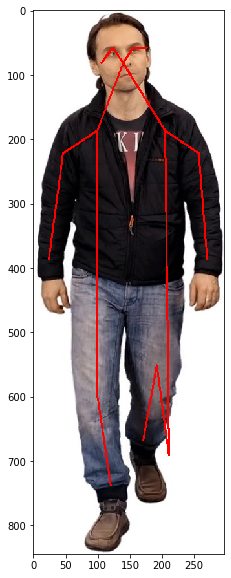

In [64]:
img3 = img.copy()
#for k in keypoints:
#    cv2.circle(img3, (int(k[0]), int(k[1])), 5, (255,0,0), -1)
for b in bones:
    kp1,kp2 = keypoints[b[0]],keypoints[b[1]]
    x1,y1, x2,y2 = int(kp1[0]),int(kp1[1]),int(kp2[0]),int(kp2[1])
    cv2.line(img3, (x1,y1), (x2,y2), (255,0,0), 2)
plt.figure(figsize=(10,10))
plt.imshow(img3)

    {0,  "Nose"},
    {1,  "LEye"},
    {2,  "REye"},
    {3,  "LEar"},
    {4,  "REar"},
    {5,  "LShoulder"},
    {6,  "RShoulder"},
    {7,  "LElbow"},
    {8,  "RElbow"},
    {9,  "LWrist"},
    {10, "RWrist"},
    {11, "LHip"},
    {12, "RHip"},
    {13, "LKnee"},
    {14, "Rknee"},
    {15, "LAnkle"},
    {16, "RAnkle"},

Done :)

In [82]:
#!curl -O "https://images.unsplash.com/photo-1484353371297-d8cfd2895020?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1179&q=80"
!curl -o people.jpg "https://images.unsplash.com/photo-1484712401471-05c7215830eb?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189k  100  189k    0     0  3004k      0 --:--:-- --:--:-- --:--:-- 3004k


In [84]:
%%writefile labels.txt
2 0.178205 0.639103 0.0230769 0.0166667 0.28052
2 0.210256 0.639744 0.034188 0.0179487 0.419109
2 0.142735 0.639744 0.0324786 0.025641 0.566589
0 0.443162 0.508974 0.217949 0.761538 0.781379
0 0.680769 0.469872 0.303419 0.765385 0.884202
0 0.263675 0.540385 0.294872 0.770513 0.907675

Overwriting labels.txt


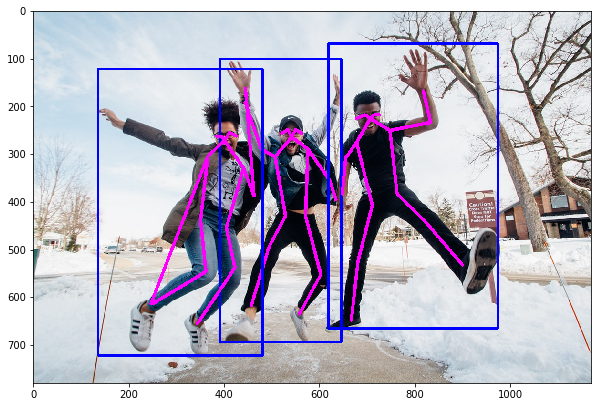

In [92]:
import numpy as np
img = cv2.imread('people.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h,w,c = img.shape
people = []
for l in open('labels.txt', 'r').readlines():
    cls_id,cx,cy,bw,bh,cnf = [float(i) for i in l.split(' ')]    
    cls_id = int(cls_id)
    bbox = (np.array([cx,cy,bw,bh], np.float32) * (w,h,w,h)).astype(np.int32)
    bbox[0:2] -= bbox[2:]//2    
    bbox[2:] += bbox[0:2]    
    
    x1,y1,x2,y2 = bbox
    if cls_id != 0 or cnf < 0.70: continue # ignore non-people
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,255), 4)
    
    people = img[y1:y2, x1:x2]
    keypoints = predict(people)
    for b in bones:
        kp1,kp2 = keypoints[b[0]],keypoints[b[1]]
        x1,y1, x2,y2 = int(kp1[0]),int(kp1[1]),int(kp2[0]),int(kp2[1])
        cv2.line(people, (x1,y1), (x2,y2), (255,0,255), 5)
    
    
cv2.imwrite('people_out.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.figure(figsize=(10,10))
plt.imshow(img)